In [23]:
import numpy as np
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss
from pennylane import NesterovMomentumOptimizer
from qcnn.qcnn import QCNN

dims = (16, 16), (28, 28), (32, 32)
num_trials = 50

In [24]:
# from thesis.quantum.operation.ansatz.convolution.v5 import ConvolutionAnsatz as A
from qcnn.quantum.operation.ansatz import BaselineAnsatz as A
from qcnn.ml.data import BinaryData
from qcnn.ml.optimize import Optimizer
from qcnn.ml.data import image_transform
from qcnn.experiment import Experiment
from qcnn.cnn import CNN

dims = (16, 16)
num_layers = 1
silent = False

data = BinaryData(FashionMNIST, image_transform(dims, flatten=False), batch_size=(500, 1000))
# optimizer = Optimizer(SGD, lr=0.01, momentum=0.9, nesterov=True)
optimizer = Optimizer(Adam)
qcnn = CNN.with_logging(data, optimizer, CrossEntropyLoss(), epoch=25)

# qcnn.ansatz = A.from_dims(dims, num_layers=num_layers)
# display(qcnn.ansatz.draw(decompose=True))

In [25]:
experiment = Experiment(qcnn, num_trials, results_schema=["accuracy"])
results = experiment(dims, num_layers, silent=silent)
# results = experiment(A, dims, silent=silent, num_layers=num_layers)

2023-06-07 11:20:48,229: (cnn_trial_0) Number of Parameters: 1193
2023-06-07 11:21:10,606: (cnn_trial_0) Accuracy: 94.000%
2023-06-07 11:21:10,623: (cnn_trial_1) Number of Parameters: 1193
2023-06-07 11:21:32,635: (cnn_trial_1) Accuracy: 95.350%
2023-06-07 11:21:32,650: (cnn_trial_2) Number of Parameters: 1193
2023-06-07 11:21:54,772: (cnn_trial_2) Accuracy: 96.250%
2023-06-07 11:21:54,790: (cnn_trial_3) Number of Parameters: 1193
2023-06-07 11:22:15,925: (cnn_trial_3) Accuracy: 95.700%
2023-06-07 11:22:15,948: (cnn_trial_4) Number of Parameters: 1193
2023-06-07 11:22:37,869: (cnn_trial_4) Accuracy: 95.200%
2023-06-07 11:22:37,889: (cnn_trial_5) Number of Parameters: 1193
2023-06-07 11:22:59,362: (cnn_trial_5) Accuracy: 93.650%
2023-06-07 11:22:59,383: (cnn_trial_6) Number of Parameters: 1193
2023-06-07 11:23:20,829: (cnn_trial_6) Accuracy: 95.000%
2023-06-07 11:23:20,849: (cnn_trial_7) Number of Parameters: 1193
2023-06-07 11:23:42,339: (cnn_trial_7) Accuracy: 95.400%
2023-06-07 11:23

KeyboardInterrupt: 

In [ ]:
from pathlib import Path
from qcnn.file import save_dataframe_as_csv

name = "1"
save_dataframe_as_csv(Path(f"results/{name}.csv"), results)

(0.93525, 0.93399, 0.009466099556645619)

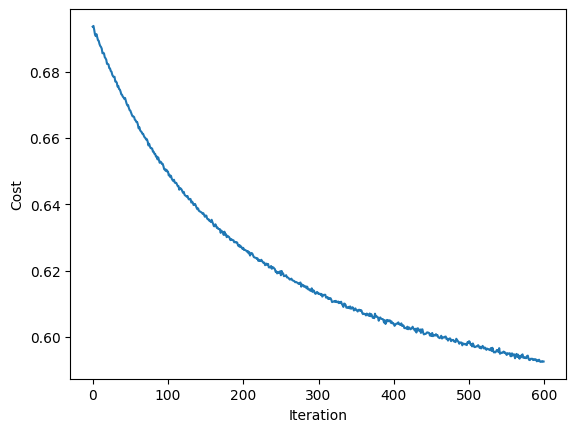

In [ ]:
experiment.draw()

acc = results["accuracy"]
acc.median(), acc.mean(), acc.std()

Variables to consider:
- __batch, epoch__
- Operation on "ancilla" qubits (pre, post, none)
- Filter Ansatz
- Fully-connected Ansatz
- Which qubits to apply Fully-connected
- Which qubits to measure